In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from tqdm import tqdm

## Using scikit-fmm
* https://github.com/scikit-fmm/scikit-fmm

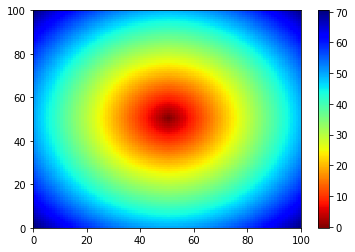

In [2]:
import skfmm
n = 100
boundary = np.ones((n,n))
boundary[int(.5*n),int(.5*n)] = -1
res = skfmm.distance(boundary)
fig, ax = plt.subplots(facecolor='white')
plot = ax.pcolormesh(res, cmap=plt.cm.jet.reversed())
fig.colorbar(plot)
#plt.savefig('skfmm.png')

## Manual - Attempt 2

In [3]:
import sys
np.set_printoptions(threshold=sys.maxsize, linewidth=200)

## Manual - Attempt 1
### didn't work as expected, I'm trying another approach

In [4]:
# Initialize initial grid, u(k, i, j)
plate_length = 100  # size of the plate/matrix to use
max_iter_time = 10  # number of timesteps
u = np.full((plate_length, plate_length), 1000)

In [5]:
# Create the label matrix
"""
Dictionary for labels
far - far
con - considered
acc - accepted
"""
labels = np.full((plate_length, plate_length), 'far')

In [6]:
# Set the initial source point
initial = int(.5*plate_length)
u[initial, initial] = 0
labels[initial, initial] = 'acc'

In [7]:
# This doesn't work and I don't know why, so I'm trying another approach
def calculate(u, labels, f=None, h=1):
    if f == None:
        f = np.ones((u.shape[0], u.shape[1]))
    for _ in range(max_iter_time):
        # calculate far node
        for i in range(1,plate_length-1):
            for j in range(1,plate_length-1):
                if labels[i, j] == 'far':
                    #print(u[i-1, j], u[i+1, j])
                    u_h = min(u[i-1, j], u[i+1, j])
                    u_v = min(u[i, j-1], u[i, j+1])
                    u_new = 0
                    val_1 = (u_h+u_v)**2
                    val_2 = 2*(u_h**2 + u_v**2 - ((h**2)/(f[i,j]**2)))
                    #print(">>1", "u_new", u_new, "u_ij", u[k, i, j])
                    #print(f'u_h {u_h} | u_v {u_v} | h {h} | f[i,j] {f[i,j]}')
                    if abs(u_h-u_v) >= h/f[i,j]:
                        u_new += min(u_h, u_v) + (h/f[i,j])
                        #print(">>2", "u_new", u_new, "u_ij", u[k, i, j])
                    else:
                        #print(">>3", "u_new", u_new, "u_ij", u[k, i, j])
                        u_new += (u_h+u_v)/2
                        #print(">>4", "u_new", u_new, "u_ij", u[k, i, j])
                        u_new += (1/2) * np.sqrt(val_1 - val_2)
                        #print(">>5", "u_new", u_new, "u_ij", u[k, i, j])
                    #print(">>6", "u_new", u_new, "u_ij", u[k, i, j])
                    if u_new < u[i, j]:
                        #print(labels)
                        #print(u_new, u[k, i, j])
                        u[i, j] = u_new
                        labels[i, j] = 'con'
        #print(labels)
        
        smallest_u = np.inf
        # find smallest u in considereds
        smallest_i = -1
        smallest_j = -1
        for i in range(plate_length):
            for j in range(plate_length):
                if labels[i, j] == 'con':
                    #print(u[k,i,j], smallest_u)
                    if u[i, j] < smallest_u:
                        smallest_u = u[i, j]
                        smallest_i = i
                        smallest_j = j
                        #print(">>>", smallest_i, smallest_j)
        
        labels[smallest_i, smallest_j] = 'acc'
        
        dir_i = [-1,0,1,0]
        dir_j = [0,-1,0,1]
        for abc in range(4):
            t_i = dir_i[abc]
            t_j = dir_j[abc]
            if labels[smallest_i+t_i, smallest_j+t_j] != 'acc':
                i = smallest_i+t_i
                j = smallest_j+t_j
                u_h = min(u[i-1, j], u[i+1, j])
                u_v = min(u[i, j-1], u[i, j+1])
                u_new = 0
                val_1 = (u_h+u_v)**2
                val_2 = 2*(u_h**2 + u_v**2 - ((h**2)/(f[i,j]**2)))
                if abs(u_h-u_v) >= h/f[i,j]:
                    u_new += min(u_h, u_v) + (h/f[i,j])
                else:
                    u_new += (u_h+u_v)/2
                    u_new += (1/2) * np.sqrt(val_1 - val_2)
                #print(u_new, u[k, i, j])
                if u_new < u[i, j]:
                    #print(labels)
                    #print(u_new, u[k, i, j])
                    u[i, j] = u_new
                    labels[i, j] = 'con'

calculate(u, labels)

In [8]:
# scales the inf values down so color map correctly shows it
flat = u.flatten()
flat.sort()
highest = list(set(flat))[-2]
u[u>50] = 2*highest

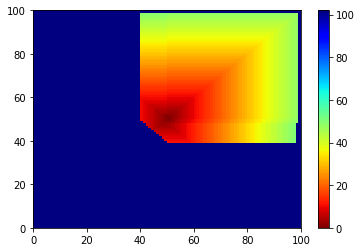

In [9]:
plt.pcolormesh(u, cmap=plt.cm.jet.reversed())
plt.colorbar()